In [1]:
import pandas as pd
import numpy as np
from numpy import array 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences 
from keras.layers import Dense, Flatten, LSTM, SpatialDropout1D 
from keras.layers.embeddings import Embedding
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/data.csv')

In [8]:
with open('data/stopwords.txt') as f:
    stopwords = {line.rstrip('\n') for line in f if '#' not in line}

In [9]:
import string
import re

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def remove_url(text):
    r = [w for w in text.split() if 'pictwittercom' in w]
    for i in r:
        text = re.sub(i, '', text)
    return text

def clean_tweet(text):
    text.encode("ascii", "ignore").decode("ascii") # remove emoji
    text = remove_pattern(text, "@[\w]*")  # Remove @mentions
    text = re.sub(r'http[s]{0,1}://[^\s]*', '', text) # remove http websites
    text = text.replace('\n',' ') # replace \n
    text = text.replace('\xa0', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = remove_url(text) 
    text = [t.lower() for t in text.split()] # lower case
    text = [w for w in text if w not in stopwords] # remove stopwords
    return " ".join(text)


In [10]:
df['clean_text'] = df['tweets'].map(clean_tweet)

In [11]:
countries = {c: i for c,i in zip(df['country'].unique(), range(9))}

In [12]:

df['country'] = df['country'].map(countries)

In [144]:
X = df['clean_text']
y = df['country']

In [146]:
y = to_categorical(y, num_classes=9)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=42,
                                                    stratify=y)

In [16]:
X_train.shape

(6591,)

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
encodings = tokenizer.texts_to_sequences(X_train)

In [18]:
vocab_length = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_length}")

Vocabulary Size: 1706095


In [19]:
tweet_lengths = [len(i) for i in encodings] 
print(f"Max Tweet Length: {max(tweet_lengths)}")
np.mean(tweet_lengths)

Max Tweet Length: 11574


3674.4821726596874

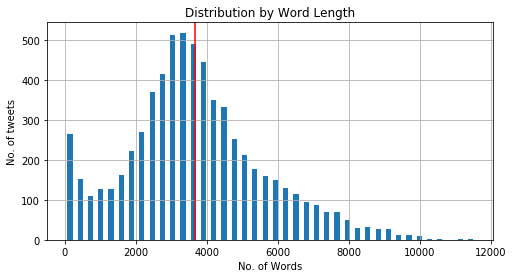

In [20]:
#visualizing distribution of words by post
length_df = pd.DataFrame(tweet_lengths)

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(tweet_lengths, bins=40, rwidth=0.5)
plt.axvline(np.mean(tweet_lengths), color='red')
ax.set_title('Distribution by Word Length')
ax.set_xlabel('No. of Words')
ax.set_ylabel('No. of tweets')
ax.grid(b=True)

In [21]:
max_length = 3000
X_train_pad = pad_sequences(encodings, maxlen=max_length, padding='post')

In [22]:
test_encodings = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(test_encodings, maxlen=max_length, padding='post')

In [23]:
#define model 
model = Sequential()
model.add(Embedding(vocab_length, 3, input_length=max_length))
model.add(Flatten())
model.add(Dense(9,activation='softmax'))

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3000, 3)           5118285   
_________________________________________________________________
flatten_1 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 81009     
Total params: 5,199,294
Trainable params: 5,199,294
Non-trainable params: 0
_________________________________________________________________


In [26]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0,patience=5, mode='auto')

In [27]:
history = model.fit(X_train_pad,
                    y_train,
                    batch_size= 16,   # batch size should be a power of 2
                    validation_data=(X_test_pad,y_test),
                    epochs=20,
                    callbacks=[early_stop],
                    verbose=1)

/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6591 samples, validate on 2198 samples
Epoch 1/20
6591/6591 [==============================] - 15s 2ms/step - loss: 1.8406 - accuracy: 0.2751 - val_loss: 1.4206 - val_accuracy: 0.4813
Epoch 2/20
6591/6591 [==============================] - 14s 2ms/step - loss: 0.6874 - accuracy: 0.8871 - val_loss: 1.0066 - val_accuracy: 0.6451
Epoch 3/20
6591/6591 [==============================] - 14s 2ms/step - loss: 0.1580 - accuracy: 0.9763 - val_loss: 0.9628 - val_accuracy: 0.6583
Epoch 4/20
6591/6591 [==============================] - 14s 2ms/step - loss: 0.0824 - accuracy: 0.9829 - val_loss: 0.9718 - val_accuracy: 0.6506
Epoch 5/20
6591/6591 [==============================] - 14s 2ms/step - loss: 0.0599 - accuracy: 0.9876 - val_loss: 0.9640 - val_accuracy: 0.6611
Epoch 6/20
6591/6591 [==============================] - 15s 2ms/step - loss: 0.0464 - accuracy: 0.9914 - val_loss: 0.9734 - val_accuracy: 0.6611
Epoch 7/20
6591/6591 [==============================] - 15s 2ms/step - loss: 0.037

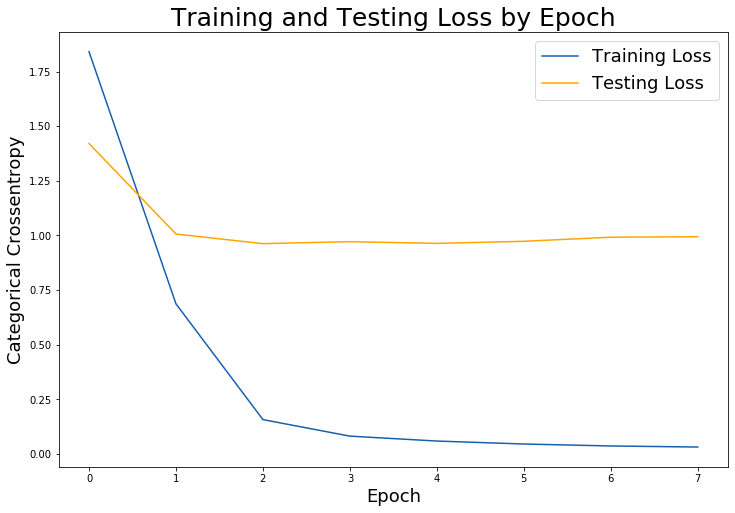

In [28]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

array([ 1006, 19856,  9292, ...,  3100, 11378,  6977], dtype=int32)

In [154]:
model.predict([[list(range(3000))]])

array([[0.00342452, 0.00656467, 0.00093527, 0.02727684, 0.28587466,
        0.07733733, 0.0252541 , 0.18146707, 0.39186552]], dtype=float32)

### XGBOOST

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [48]:

tfidf_vectorizer = TfidfVectorizer(max_features=500)
X = tfidf_vectorizer.fit_transform(df['clean_text'])

In [49]:
y = df['country']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=42)

In [51]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [52]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred= xgb.predict(X_test);
acc = accuracy_score(y_test, y_pred);

In [53]:
print('Accuracy score:', acc)

Accuracy score: 0.8316651501364877


In [54]:
confusion_matrix(y_test, y_pred)

array([[202,   3,   2,   4,   1,   5,   9,   3,  16],
       [  9, 196,  25,   1,   1,   6,   0,   2,   1],
       [  5,  14, 211,   1,   0,   4,   2,   2,   2],
       [  4,   3,   1, 198,   7,   3,  15,  11,   5],
       [  2,   0,   0,  11, 216,   1,   4,   1,  12],
       [  6,   8,   2,   1,   1, 209,   2,   1,   2],
       [  2,   0,   1,   5,   0,   0, 212,  22,   8],
       [ 17,   3,   3,   3,   1,   2,  31, 174,  11],
       [  7,   1,   5,   7,   0,   1,   9,  10, 210]])

### Testing with unseen data

In [239]:
import json

test_df = pd.read_csv('konghee.csv')

In [240]:
test_df['clean_text'] = test_df['tweet'].map(clean_tweet)

In [241]:
test_data = ' '.join(test_df['clean_text'])

In [242]:
test_data = tfidf_vectorizer.transform([test_data])

In [243]:
xgb.predict(test_data)[0]

1

In [110]:
from joblib import load

xgb_country = load("xgb_country.joblib")
tfidf_vectorizer = load("tfidf_vectorizer.joblib")

In [111]:
test_data = tfidf_vectorizer.transform([test_data])

In [112]:
xgb_country.predict(test_data)[0]

'singapore'

In [63]:
countries

{'belgium': 0,
 'malaysia': 1,
 'indonesia': 2,
 'australia': 3,
 'new-zealand': 4,
 'singapore': 5,
 'united-states': 6,
 'canada': 7,
 'united-kingdom': 8}

In [243]:
xgb.predict_proba(test_data)

array([[0.01821221, 0.00153429, 0.02394952, 0.00236149, 0.14226578,
        0.00241576, 0.79460835, 0.00842899, 0.00622364]], dtype=float32)

In [43]:
xgb.classes_

array(['australia', 'belgium', 'canada', 'indonesia', 'malaysia',
       'new-zealand', 'singapore', 'united-kingdom', 'united-states'],
      dtype=object)

In [68]:
from joblib import dump

dump(xgb, 'xgb_country.joblib')

['xgb_country.joblib']

In [75]:
dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

In [98]:
from collections import Counter

In [99]:
pred = xgb.predict(X_test)

In [103]:
pred[0]

'malaysia'

In [132]:
a = []
for i,c in enumerate(y_test):
    if pred[i] == c:
        a.append(i)

In [133]:
b = []
for i in a:
    b.append(y_test.index[i])

In [ ]:
df[df[]]

In [136]:
df2 = df.loc[b]

In [223]:
df2['clean'] = df2[df2['country'] == 'united-states']['tweets'].map(clean_tweet)

In [224]:
sg = ' '.join(df2[df2['country'] == 'united-states']['clean'])

In [150]:
from nltk.corpus import stopwords 

In [157]:
with open('stopwords.txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content]

In [162]:
stopwords = content[6:]

In [208]:
numbers = [str(i) for i in list(range(10))]

In [209]:
stopwords.extend(numbers)

In [225]:
words = [w.lower() for w in sg.split() if w.lower() not in stopwords]

In [226]:
len (words)

729750

### Singapore

In [234]:
!pip install wordcloud

     |████████████████████████████████| 163kB 3.5MB/s eta 0:00:01


In [235]:
from wordcloud import WordCloud

### Singapore

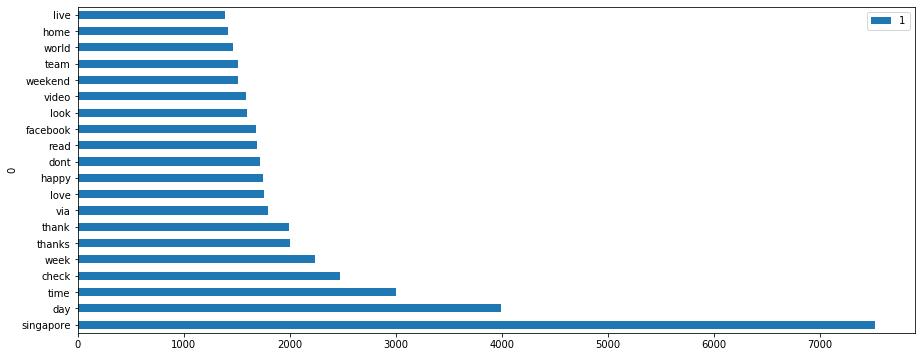

In [212]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(20,10))
pd.DataFrame(Counter(words).most_common(20)).set_index(0).plot(kind='barh', figsize=(15,6))

### Australia

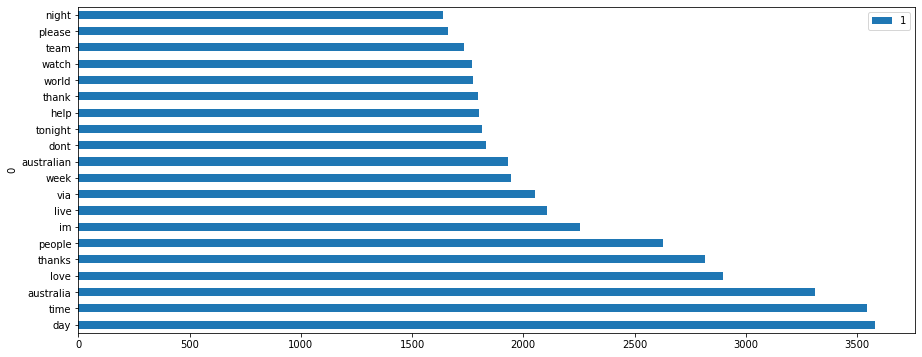

In [217]:
pd.DataFrame(Counter(words).most_common(20)).set_index(0).plot(kind='barh', figsize=(15,6))

### Malaysia

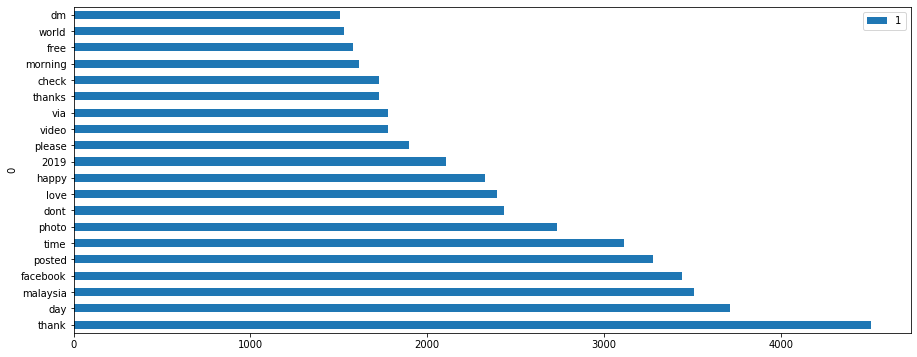

In [222]:
pd.DataFrame(Counter(words).most_common(20)).set_index(0).plot(kind='barh', figsize=(15,6))

### United states

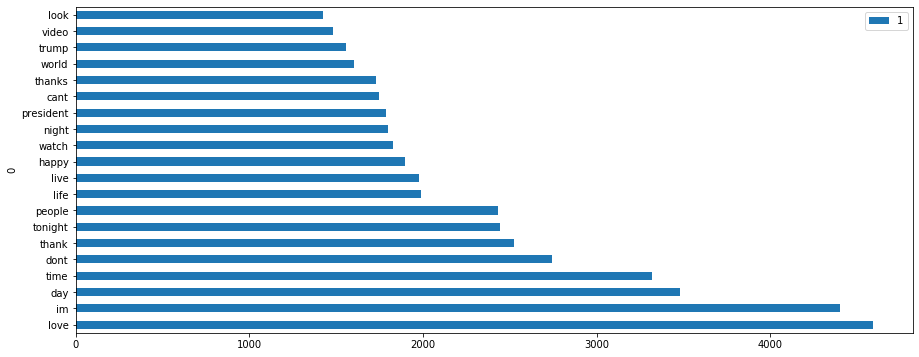

In [227]:
pd.DataFrame(Counter(words).most_common(20)).set_index(0).plot(kind='barh', figsize=(15,6))